# Tutorial Notebook for nisarhdf.nisarGUNWHDF
---

This notebook demonstrates the functionality of `nisarGUNWHDF`, which is at tool for reading NISAR **GUNW** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

The easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from osgeo import gdal
import getpass
import os

In [2]:
if not os.path.exists('./output'):
    os.mkdir('./output')

## Open the HDF

Edit the path below to point to the ROFF product you wish to work with.

In [3]:
if getpass.getuser() in ['jovyan']:
    GUNWFile = 's3://nisar-st-data-ondemand/ALOS-2-data/INSAR/cryo_sample_products_092024/frame_280/insar_products/GUNW_ALOS2496725280-230804_ALOS2498795280-230818.h5'
else:
    GUNWFile = '/Volumes/insar1/ian/NISAR/frame_280/insar/products/GUNW_ALOS2496725280-230804_ALOS2498795280-230818.h5'# Modify to local file path

Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [4]:
myGUNW = nisarhdf.nisarGUNWHDF(productType='unwrappedInterferogram')
myGUNW.openHDF(GUNWFile , referenceOrbitXML=None, secondaryOrbitXML=None,
               referenceOrbit=49672, secondaryOrbit=49879, frame=5280)

GUNW referenceZeroDopplerStartTime


Because of the different sizes, wrapped and unwrapped interferograms need to be opened as seperate `nisarGUNWHDF` instances.

In [5]:
myGUNWwrapped = nisarhdf.nisarGUNWHDF(productType='wrappedInterferogram')
myGUNWwrapped.openHDF(GUNWFile, referenceOrbitXML=None, secondaryOrbitXML=None,
                       referenceOrbit=49672, secondaryOrbit=49879, frame=5280)

GUNW referenceZeroDopplerStartTime


## GUNW Parameters

A summary of some of the more important parameters for the **GUNW** products can be obtained by.

In [6]:
myGUNW.printParams()

GUNW.referenceOrbit = 49672 
GUNW.frame = 5280 
GUNW.datetime = 2023-08-04 14:57:47.166045 
GUNW.referenceGranule = rslc_ALOS2496725280-230804.h5 
GUNW.SLCNearRange = 814637.0 
GUNW.SLCFarRange = 852284.282920905 
GUNW.SLCFirstZeroDopplerTime = 53867.166045 
GUNW.SLCLastZeroDopplerTime = 53877.165933569675 
GUNW.secondaryOrbit = 49879 
GUNW.secondaryDatetime = 2023-08-18 14:57:47.171967 
GUNW.secondaryGranule = rslc_ALOS2498795280-230818.h5 
GUNW.LookDirection = right 
GUNW.PassType = descending 
GUNW.Wavelength = 0.23840349999999996 
GUNW.PRF = 3051.234 
GUNW.epsg = 3031 
GUNW.xSize = 1211 
GUNW.ySize = 1210 
GUNW.NumberRangeLooks = 34 
GUNW.NumberAzimuthLooks = 34 

Data Fields
GUNW.coherenceMagnitude
GUNW.connectedComponents
GUNW.ionospherePhaseScreen
GUNW.ionospherePhaseScreenUncertainty
GUNW.unwrappedPhase


## Display Data

The following plots the fields associated with the unwrapped phase.

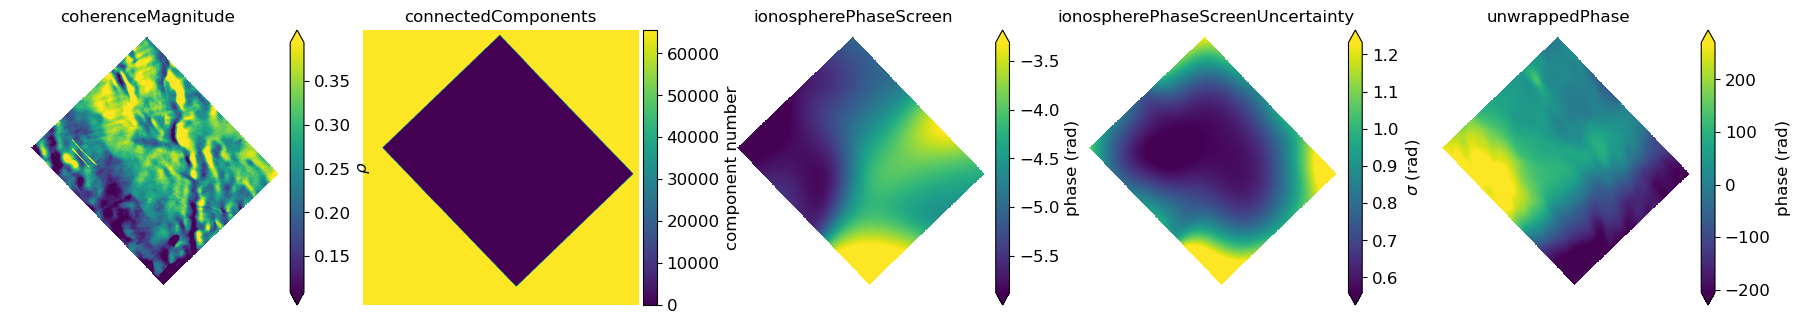

In [7]:
fields = myGUNW.dataFields
labels = dict(zip(fields, ['$\\rho$', 'component number', 'phase (rad)', '$\\sigma$ (rad)', 'phase (rad)']))
fig, axes = plt.subplots(1, len(fields), figsize=(22, 4))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myGUNW, field)
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    if field not in ['connectedComponents']:
        h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='upper')
        nisarhdf.colorBar(h, ax, labels[field], 'right', '5%',.05, 12, 12, extend='both')
    else:
        h = ax.imshow(data)
        nisarhdf.colorBar(h, ax, labels[field],'right', '5%',.05, 12, 12, extend='neither')
    ax.set_title(field)
    ax.axis('off')

The wrapped interferogram can be plotted as:

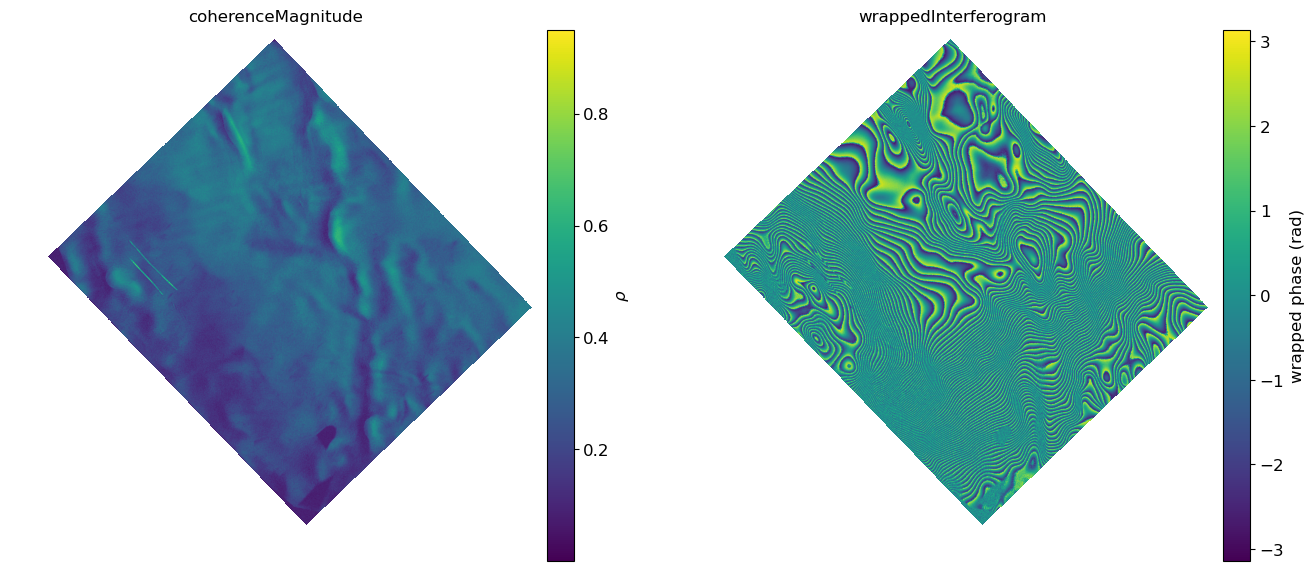

In [8]:
fieldsWrapped = myGUNWwrapped.dataFields
labelsWrapped = dict(zip(fieldsWrapped, ['$\\rho$',  'wrapped phase (rad)']))
fig, axes = plt.subplots(1, len(fieldsWrapped), figsize=(16, 10))
for field, ax in zip(fieldsWrapped, axes.flatten()):
    data = getattr(myGUNWwrapped, field)
    if field == 'wrappedInterferogram':
        data = np.angle(data)
    h = ax.imshow(data, origin='upper')
    nisarhdf.colorBar(h, ax, labelsWrapped[field],'right', '5%',.05, 12, 12, extend='neither')
    ax.set_title(field)
    ax.axis('off')

## Masking 

### Connected Components Masking

In general, the areas where the connected components are zero have data of questionable quality and its often better to mask them. 

In [9]:
myGUNW.maskPhase(largest=True)

13847
smallLabels []


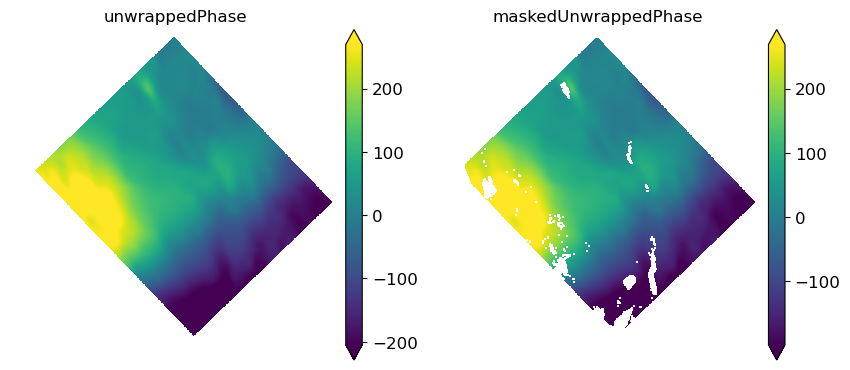

In [10]:
fields = ['unwrappedPhase', 'maskedUnwrappedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(10, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myGUNW, field) 
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    h = ax.imshow(data, origin='upper', vmin=vmin, vmax=vmax)
    nisarhdf.colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.set_title(field)
    ax.axis('off')

### Mask File

Its often useful to apply a mask from elsewhere. For example, a water mask. If the mask is saved with the same geometry as the unwrapped phase, this can be done with `myRUNW.applyMask`. As an example, the following will make a mask fild based on the correlation.

In [11]:
mask = np.ones(myGUNW.unwrappedPhase.shape, dtype='u1')
# Mask regions with correlation < 0.15
mask[myGUNW.coherenceMagnitude < 0.15] = 0
# Save the mask to a file
with open('mask', 'w') as fpOut:
    mask.tofile(fpOut)
# Create a vrt
drv = gdal.GetDriverByName("VRT")
vrt = drv.Create('mask.vrt', myGUNW.xSize, myGUNW.ySize, bands=0, eType=gdal.GDT_Byte)
vrt.SetGeoTransform([myGUNW.x0 -myGUNW.dx/2, myGUNW.dx/2, 0.,  myGUNW.y0 -myGUNW.dy/2, 0., -myGUNW.dy/2])
options = [f"SourceFilename=mask", "relativeToVRT=1", "subclass=VRTRawRasterBand"]
vrt.AddBand(gdal.GDT_Byte, options=options)
band = vrt.GetRasterBand(1)
vrt = None

Now the mask can be applied as shown below. Note if a mask as already been applied as in the example above, this masking will be combined with the prior mask.

In [12]:
myGUNW.applyMask('mask.vrt')

With the projected coordinates, the plots follow the convention in which the data are stored in the HDF with the origin as the upper-left corner (first line), so `imshow` is called with `origin='upper'` (the default). As a result, the extent must be set for upper-left corner, which is set as `extent=myRUNW.extentUL`.

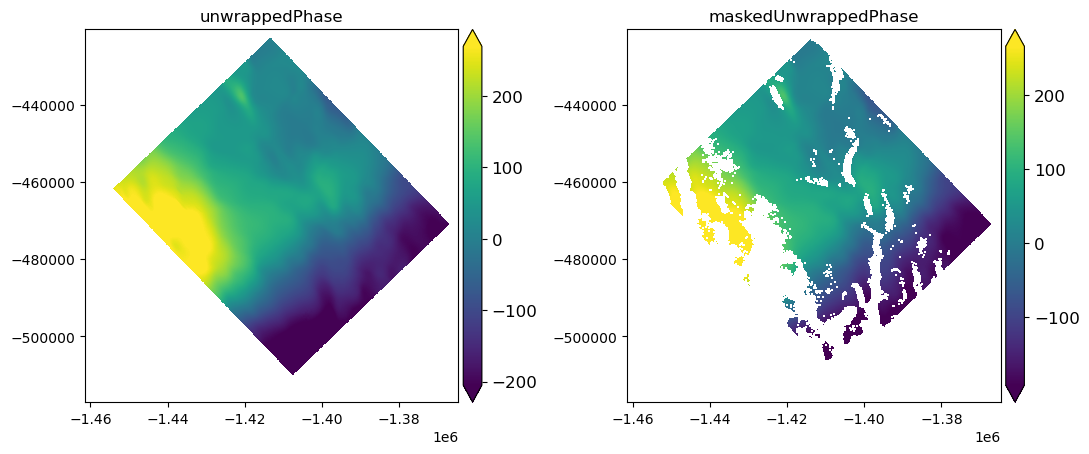

In [13]:
fields = ['unwrappedPhase', 'maskedUnwrappedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(11, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myGUNW, field) 
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, extent=myGUNW.extentUL, origin='upper')
    nisarhdf.colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.set_title(field)
fig.tight_layout()

## Ionosphere Correction

The ionosphere phase screen can removed from either the masked or unmasked unwrapped phase.

In [14]:
# masked=True to apply to the masked version of the phase
myGUNW.ionosphereCorrectPhase(masked=True)

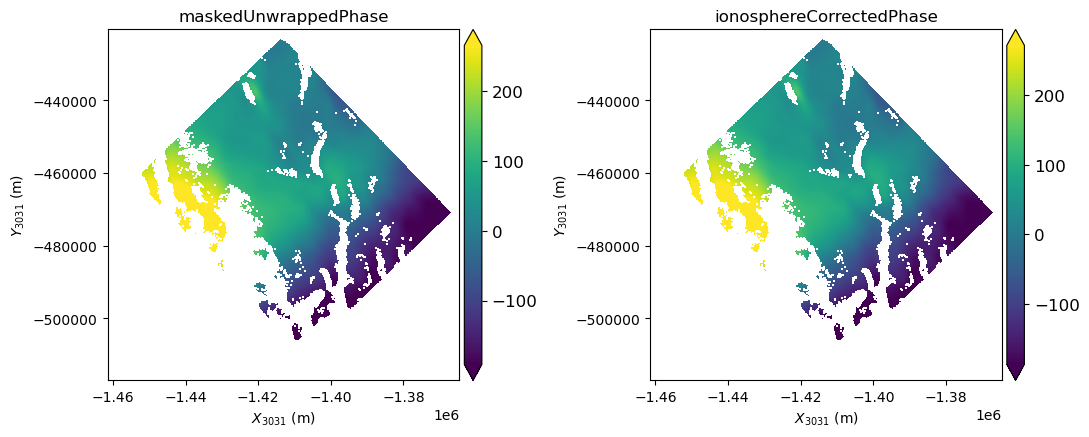

In [15]:
fields = ['maskedUnwrappedPhase', 'ionosphereCorrectedPhase']
fig, axes = plt.subplots(1, len(fields), figsize=(11, 5))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myGUNW, field) 
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, extent=myGUNW.extentUL, origin='upper')
    nisarhdf.colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend='both')
    ax.set_title(field)
    ax.set_xlabel(f'$X_{{{myGUNW.epsg}}}$ (m)')
    ax.set_ylabel(f'$Y_{{{myGUNW.epsg}}}$ (m)')
fig.tight_layout()    

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored as metadata cubes (see nisar documenation). These cubes can be interpolatated to obtain the x, y, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

For each field, there is an interpolator method (e.g., `myGUNW.incidenceAngleCube(x, y, z)`). The examples below demonstrate how to interpolate the data cubes to the coordinates of the GUNW product.

### Setup Grid for the Offsets

In this step a range/Dopper grid corresponding to the offset maps is created. Note in this example we assume zero elevation, but the values can easily be substituted from a DEM.

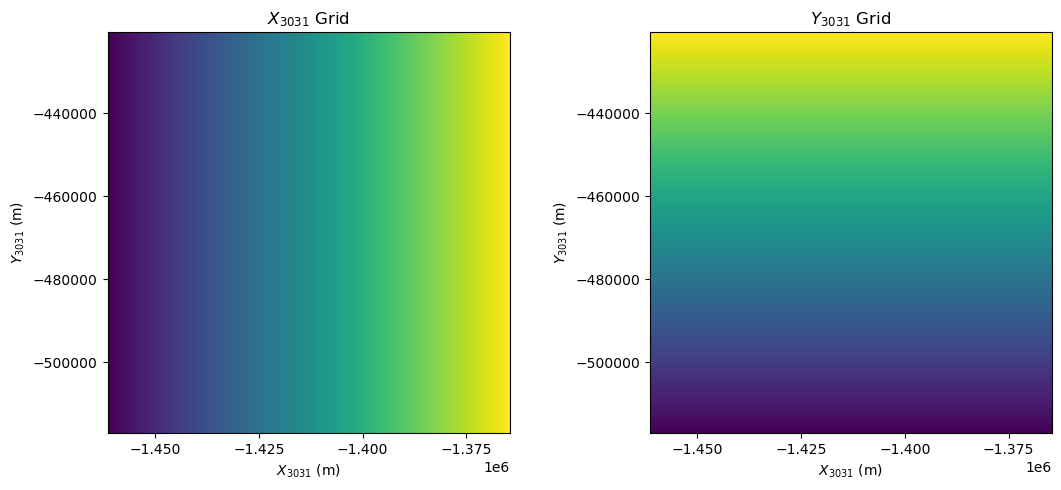

In [16]:
myGUNW.setupXYGrid()
z = np.zeros(myGUNW.xGrid.shape)
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(myGUNW.xGrid, extent=myGUNW.extentUL)
axes[1].imshow(myGUNW.yGrid, extent=myGUNW.extentUL)
for ax, field in zip(axes, [f'$X_{{{myGUNW.epsg}}}$ Grid',f'$Y_{{{myGUNW.epsg}}}$ Grid']):
    ax.set_title(field)
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel(f'$X_{{{myGUNW.epsg}}}$ (m)')
    ax.set_ylabel(f'$Y_{{{myGUNW.epsg}}}$ (m)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

incidenceAngle min/max: 38.061 41.644
elevationAngle min/max: 33.976 37.038


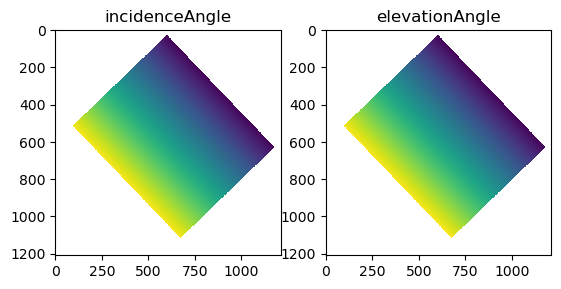

In [17]:
incidenceAngle = myGUNW.incidenceAngleCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations)
elevationAngle = myGUNW.elevationAngleCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocity is found by:

groundTrackVelocity min/max: 6859.901 6864.720


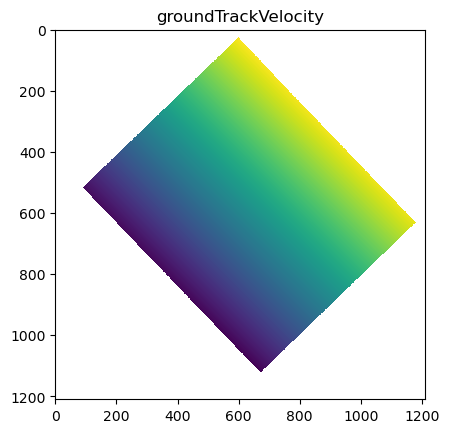

In [18]:
groundTrackVelocity=  myGUNW.groundTrackVelocityCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity, origin='upper')
ax.set_title('groundTrackVelocity')
print(f'groundTrackVelocity min/max: {np.nanmin(groundTrackVelocity):.3f} {np.nanmax(groundTrackVelocity):.3f}')

### Range-Doppler Coordinate

The `slantRange` and `zeroDopplerTime` coordinate at corresponding to the `x` and `y` can can be determined as:

slantRange min/max: 815601.966 852883.828
zeroDopplerTime min/max: 53867.216 53877.122


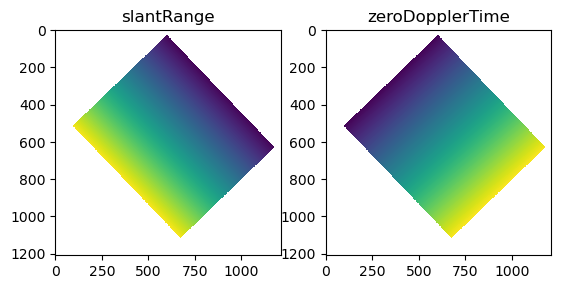

In [19]:
slantRange, zeroDopplerTime =  myGUNW.rangeDopplerCube(myGUNW.xGrid, myGUNW.yGrid, z, image='reference', maskNoData=myGUNW.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [slantRange, zeroDopplerTime], ['slantRange', 'zeroDopplerTime']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

## Baseline Components

The perpendicular and parallel baseline components are computed as follows:

bn min/max: 91.328 96.576
bp min/max: 74.614 76.318


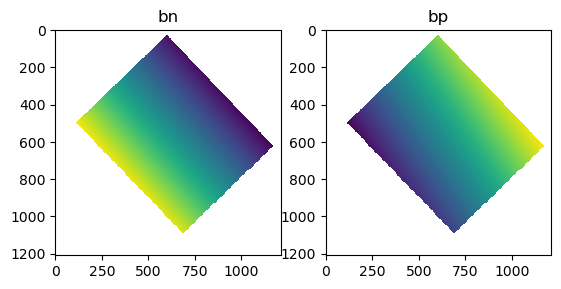

In [20]:
bn, bp =  myGUNW.baselineCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [bn, bp], ['bn', 'bp']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

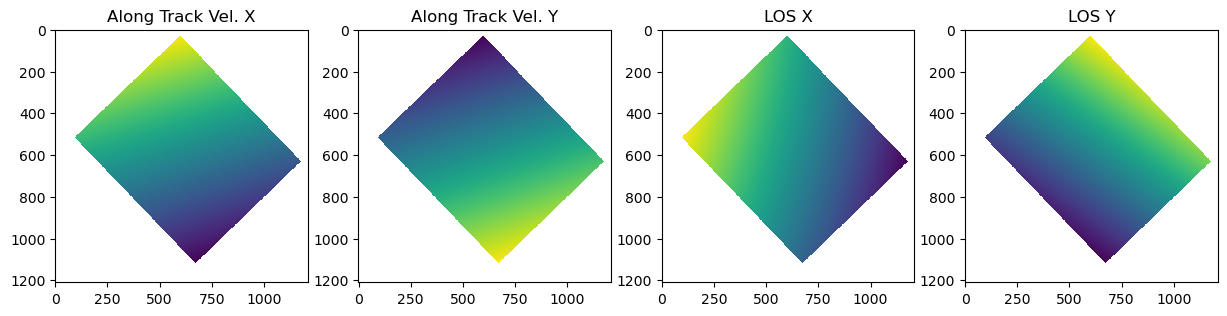

In [21]:
ATx, ATy =  myGUNW.alongTrackUnitVectorCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations)
LOSx, LOSy=  myGUNW.losUnitVectorCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [22]:
np.array(myGUNW.h5['GUNW']['grids']['frequencyA']['centerFrequency']).item()

1257500238.0418074

## Save Data to Binary or Tiff Files.

The data from the hdf can be save as individual tiffs, bound together by a single vrt file. The default is to write all of the bands e.,g `'coherenceMagnitude', 'connectedComponents', 'ionospherePhaseScreen', 'ionospherePhaseScreenUncertainty',' and `'unwrappedPhase'` for a **GUNW** product, which is accomplished as follows.

In the previous example, the results were save as tiffs. To save as binary files, run with `tiff=False` for a more limited set of bands:

In [23]:
myGUNW.writeData('output/GUNWbinary', bands=['coherenceMagnitude', 'unwrappedPhase'], tiff=False)
!ls output/GUNWbinary*

output/GUNWbinary.coherenceMagnitude  output/GUNWbinary.vrt
output/GUNWbinary.unwrappedPhase      output/GUNWbinary.vrt~


The data can be read back in as an `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

<xarray.Dataset>
Dimensions:             (x: 1211, y: 1210)
Coordinates:
  * x                   (x) float64 -1.461e+06 -1.461e+06 ... -1.365e+06
  * y                   (y) float64 -4.204e+05 -4.204e+05 ... -5.171e+05
    spatial_ref         int64 0
Data variables:
    coherenceMagnitude  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    unwrappedPhase      (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/22)
    bands:                    ['coherenceMagnitude', 'unwrappedPhase']
    ByteOrder:                LSB
    datetime:                 2023-08-04 14:57:47.166045
    epsg:                     3031
    frame:                    5280
    LookDirection:            right
    ...                       ...
    SLCFirstZeroDopplerTime:  53867.166045
    SLCLastZeroDopplerTime:   53877.165933569675
    SLCNearRange:             814637.0
    Wavelength:               0.23840349999999996
    xSize:                    1211
    ySize:                    1210

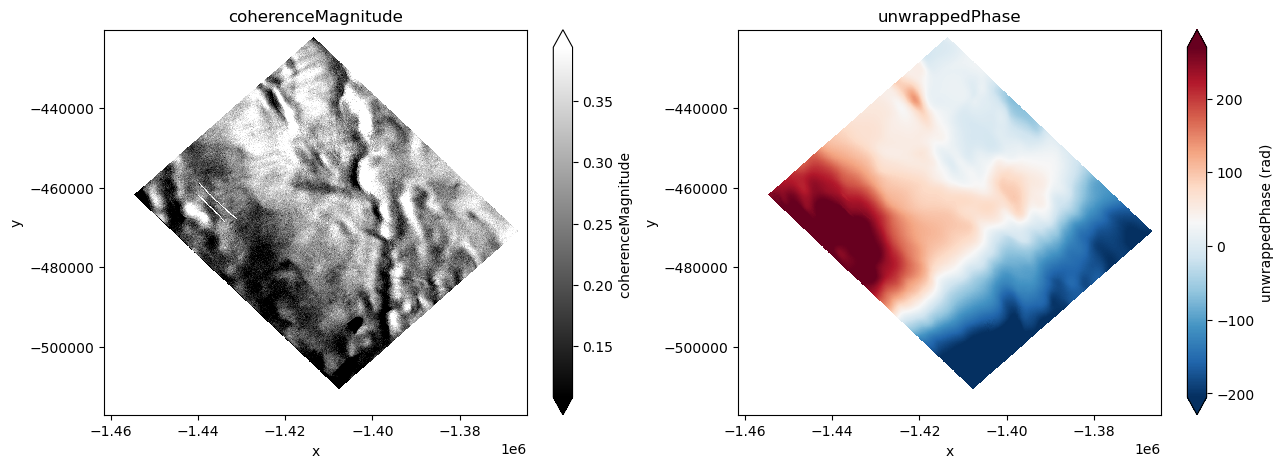

In [24]:
GUNWbinary = nisarhdf.readVrtAsXarray('output/GUNWbinary.vrt', mask_and_scale=True)
#extent = [np.min(GUNWbinary.x), np.max(GUNWbinary.x), np.min(GUNWbinary.y), np.max(GUNWbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for var, ax, cmap, units in zip(GUNWbinary.data_vars, axes.flatten(), ['gray', 'RdBu_r'], ['', '(rad)']):
    vmin, vmax = nisarhdf.autoScaleRange(GUNWbinary[var].data, 95)
    GUNWbinary[var].plot.imshow(ax=ax, cmap=cmap, cbar_kwargs={'label': f'{var} {units}'}, vmin=vmin, vmax=vmax)
    ax.set_title(var)
#GUNWbinary.coherenceMagnitude.plot.imshow(ax=axes[0], cmap='gray')
#GUNWbinary.unwrappedPhase.plot.imshow(ax=axes[1], cmap='RdBu_r')
GUNWbinary

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [25]:
myGUNW.incidenceAngleCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations, save=True);
myGUNW.elevationAngleCube(myGUNW.xGrid, myGUNW.yGrid, z, maskNoData=myGUNW.noDataLocations, save=True);
myGUNW.writeData('output/GUNWangles',bands=['incidenceAngle', 'elevationAngle'], tiff=True) # ', 'elevationAngle'

<xarray.Dataset>
Dimensions:         (x: 1211, y: 1210)
Coordinates:
  * x               (x) float64 -1.461e+06 -1.461e+06 ... -1.365e+06 -1.365e+06
  * y               (y) float64 -4.204e+05 -4.204e+05 ... -5.17e+05 -5.171e+05
    spatial_ref     int64 0
Data variables:
    incidenceAngle  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    elevationAngle  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/22)
    bands:                    ['incidenceAngle', 'elevationAngle']
    ByteOrder:                LSB
    datetime:                 2023-08-04 14:57:47.166045
    epsg:                     3031
    frame:                    5280
    LookDirection:            right
    ...                       ...
    SLCFirstZeroDopplerTime:  53867.166045
    SLCLastZeroDopplerTime:   53877.165933569675
    SLCNearRange:             814637.0
    Wavelength:               0.23840349999999996
    xSize:                    1211
    ySize:                    1210

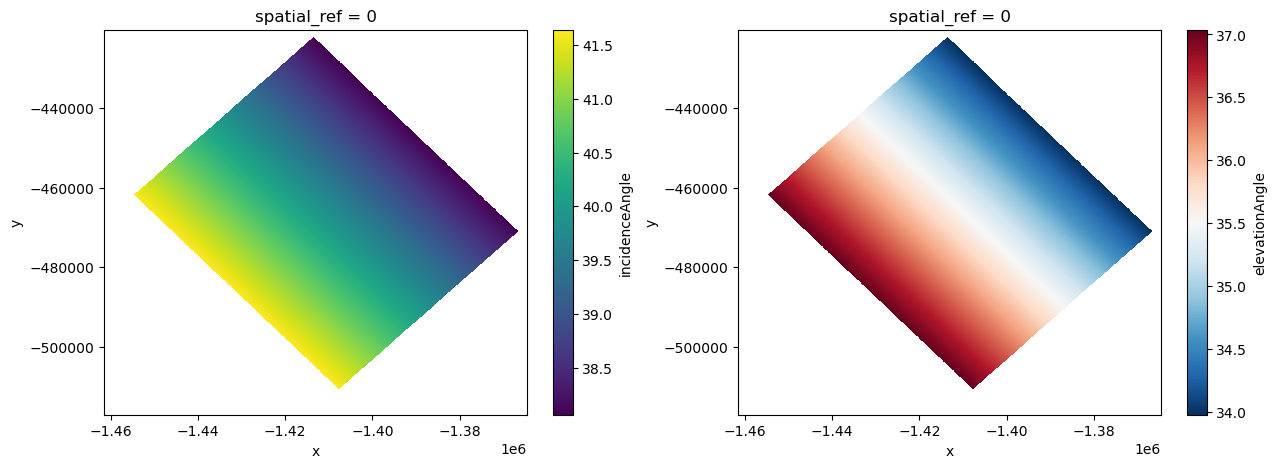

In [26]:
GUNWTiff = nisarhdf.readVrtAsXarray('output/GUNWangles.vrt', mask_and_scale=True)
#extent = [np.min(GUNWbinary.x), np.max(GUNWbinary.x), np.min(GUNWbinary.y), np.max(GUNWbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
GUNWTiff.incidenceAngle.plot.imshow(ax=axes[0])
GUNWTiff.elevationAngle.plot.imshow(ax=axes[1], cmap='RdBu_r')
GUNWTiff

# Anything below here is debug code that can be ignored